# Dam Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.integrate as sp
from scipy.interpolate import interp1d
from matplotlib.patches import Rectangle

In [2]:
dates, times, flow = np.loadtxt('data/water.csv', unpack = True, usecols = (2, 3, 5), dtype=object)
flow = np.array(flow, dtype=float)
t = np.zeros(dates.size)
for i in range(dates.size):
    d = datetime.strptime(dates[i]+times[i], '%Y-%m-%d%H:%M')
    t[i] = d.timestamp()
start_time = t[0]
t -= start_time

## Visualizing the data

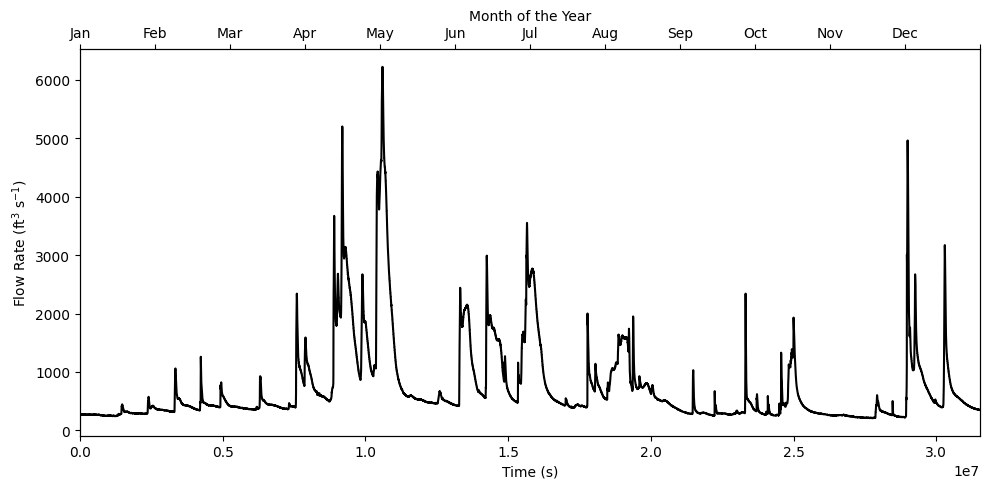

In [310]:
fig, ax = plt.subplots(figsize = (10,5))

ax.plot(t, flow, 'k')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
ax.set_xlim(0, t[-1])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.linspace(0, t[-1], 13))
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])
ax2.set_xlabel('Month of the Year')
plt.tight_layout()
plt.savefig('plots/2/dams.png', dpi=200)

## Theory
Let $f(t)$ be the flow rate of water and $W(T)$ be the total amount of water discharge of the dam in time $T$. Then, 


$$
f(t) = \frac{dW}{dt}
\implies W(T) = \int_0^T f(t)dt
$$

Let us first work with a small snippet of the data which contains a sharp peak.

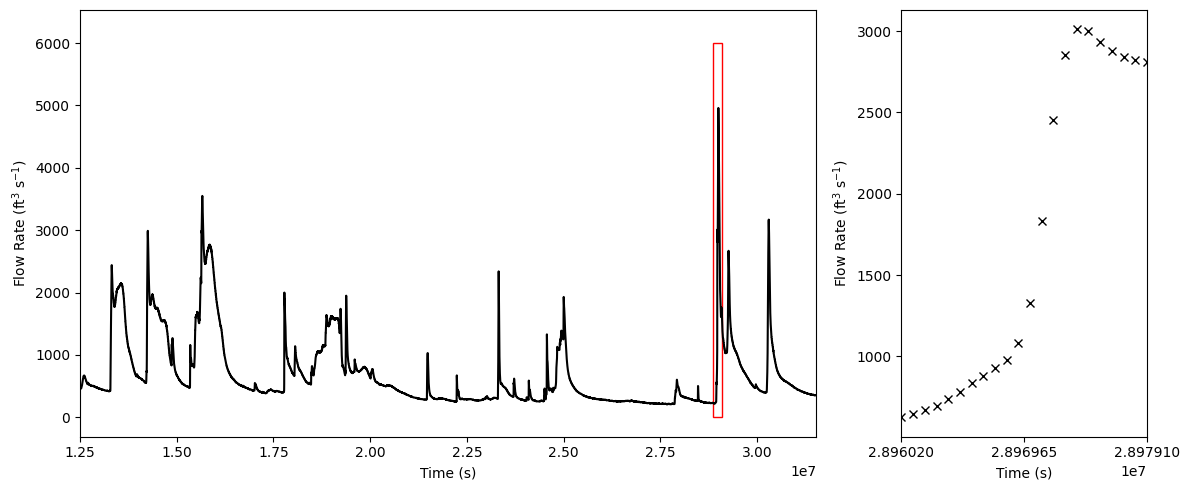

In [311]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (12,5), gridspec_kw={'width_ratios': [3, 1]})

ax[0].plot(t, flow, 'k')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
ax[0].set_xlim(1.25e7, t[-1])
simpsons_38, b = 2.885e7, 2.91e7
rect = Rectangle((simpsons_38, 0), (b-simpsons_38), 6000, linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

roi = np.where((t>2.896e7) & (t<2.898e7))
f1 = flow[roi]
t1 = t[roi]
ax[1].plot(t1, f1, 'kx', alpha=1)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
ax[1].set_xlim(t1[0], t1[-1])
ax[1].set_xticks(np.linspace(t1[0], t1[-1], 3))
plt.tight_layout()
plt.savefig('plots/2/zoom.png', dpi=200)

In [4]:
roi = np.where((t>2.896e7) & (t<2.898e7))
f1 = flow[roi]
t1 = t[roi]
t1 = (t1-np.min(t1)) # changing the range of x from 0 to 1 for simplicity
t1 = t1/np.max(t1)
dx = t1[1]-t1[0]

## Integration Techniques

### Mid-point rule

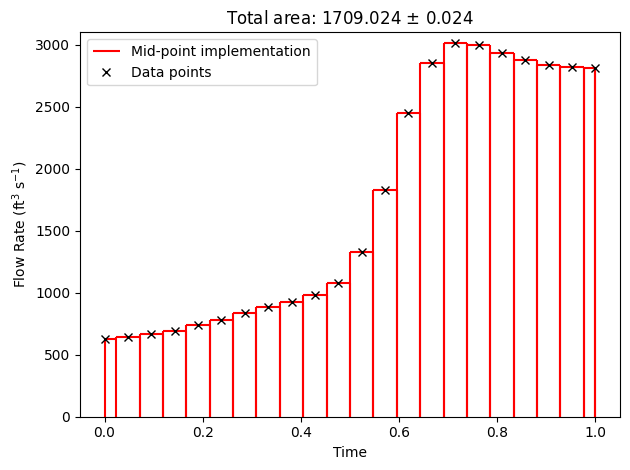

In [ ]:
half_step = dx/2

def d2dt(y,h=1):
    diffs = np.zeros(len(y))
    for x in range(2, len(y)-2):
        diffs[x] = (y[x+1]+y[x-1]-2*y[x])/(h**2)
    return diffs

def mid_point_integration(x, y):
    half_step = (x[1]-x[0])/2
    res = 0
    res += y[0]*half_step
    for i in range(1,len(x)-1):
        res += y[i]*half_step*2
    res += y[-1]*half_step

    f2epsilon = np.max(abs(d2dt(y)))
    max_error_mid_point = ((x[-1]-x[0]) * f2epsilon * dx**2)/(24)
    return res, max_error_mid_point

plt.vlines(t1[0], ymax=f1[0], ymin=0, color='r')
plt.hlines(f1[0], xmin=t1[0], xmax=t1[0]+half_step, color='r')
for i in range(1,len(t1)-1):
    plt.vlines(t1[i]-half_step, ymax=f1[i], ymin=0, color='r')
    plt.vlines(t1[i]+half_step, ymax=f1[i], ymin=0, color='r')
    plt.hlines(f1[i], xmin=t1[i]-half_step, xmax=t1[i]+half_step, color='r')

plt.vlines(t1[-1]-half_step, ymax=f1[-1], ymin=0, color='r')

plt.vlines(t1[-1], ymax=f1[-1]-half_step, ymin=0, color='r', label='Mid-point implementation')
plt.vlines(t1[-1], ymax=f1[-1], ymin=0, color='r')
plt.hlines(f1[-1], xmin=t1[-1], xmax=t1[-1]-half_step, color='r')
plt.plot(t1, f1, 'kx', alpha=1, label='Data points')

plt.legend()
plt.xlabel('Time')
plt.ylim(0,3100)
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
mid_point, max_error_mid_point = mid_point_integration(t1, f1, dx)
plt.title(f'Total area: {mid_point:.3f}' + r' $\pm$ ' + f'{max_error_mid_point:.3f}')
plt.tight_layout()
plt.savefig('plots/2/mid-point.png', dpi=200)

### Trapezoidal Rule

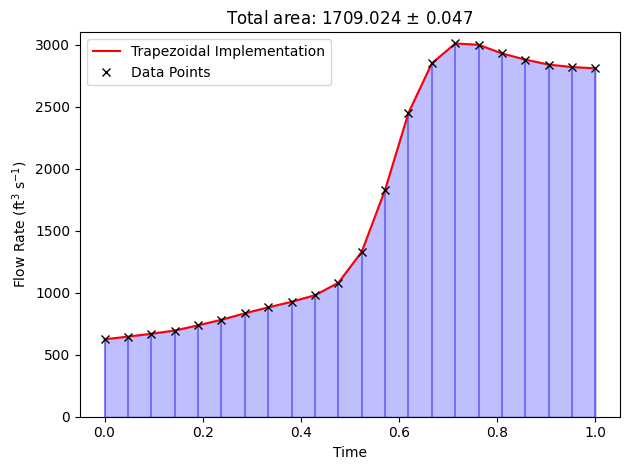

In [ ]:
def trapezoidal_integration(x, y, dx):
    res = (dx/2) * (y[0] + 2*np.sum(y[1:-1]) + y[-1])
    f2epsilon = np.max(abs(d2dt(y)))
    max_error_trapz = ((x[-1]-x[0]) * f2epsilon * dx**2)/(12)
    return res, max_error_trapz

plt.vlines(t1[0], ymax=f1[0], ymin=0, color='b', alpha=0.4)
plt.fill_between(t1, f1, 0, alpha = 0.25, color='b')
for i in range(1,len(t1)-1):
    plt.vlines(t1[i], ymax=f1[i], ymin=0, color='b', alpha=0.4)
plt.vlines(t1[-1], ymax=f1[-1], ymin=0, color='b', alpha=0.4)
plt.plot(t1, f1, '-r', alpha=1, label='Trapezoidal Implementation')
plt.plot(t1, f1, 'kx', alpha=1, label='Data Points')

plt.legend()
plt.xlabel('Time')
plt.ylim(0,3100)
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')

trapezoidal, max_error_trapz = trapezoidal_integration(t1, f1, dx)
plt.title(f'Total area: {trapezoidal:.3f}' + r' $\pm$ ' + f'{max_error_trapz:.3f}')
plt.tight_layout()
plt.savefig('plots/2/trapezoidal.png', dpi=200)

### Simpsons 1/3 Rule

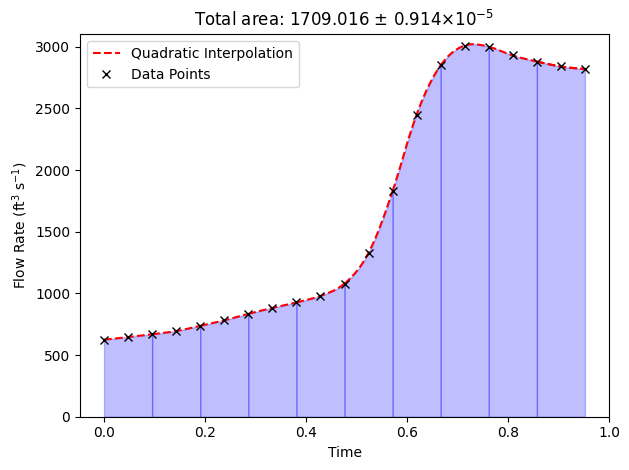

In [ ]:
def d4dt(y,h=1):
    diffs = np.zeros(len(y))
    for x in range(2, len(y)-2):
        diffs[x] = (y[x+2]-4*y[x+1]+6*y[x]-4*y[x-1]+y[x-2])/h**4
    return diffs

def simpsons_13_integration(x, y, dx):
    # If there are an even number of samples, N, then there are an odd
    # number of intervals (N-1), but Simpson's rule requires an even number
    # of intervals. Hence we perform simpson's rule on the first and last (N-2)
    # intervals, take the average and add up the end points using trapezoidal rule
    if len(x) % 2 == 0:
        res = (dx/3) * (y[0] + 4*np.sum(y[1:-2:2]) + 2*np.sum(y[2:-2:2]) + y[-3])
        res += (dx/3) * (y[1] + 4*np.sum(y[2:-1:2]) + 2*np.sum(y[3:-1:2]) + y[-2])
        res /= 2
        res += 0.5*dx*(y[0] + y[-1])
    else:
        res = (dx/3) * (y[0] + 4*np.sum(y[1:-1:2]) + 2*np.sum(y[2:-1:2]) + y[-1])
    f4epsilon = np.max(abs(d4dt(y)))
    max_error_simpsons_13 = ((x[-1]-x[0]) * f4epsilon * (dx**4))/(180)
    return res, max_error_simpsons_13

""" plotting quadratic interpolation"""
cubic = interp1d(t1, f1, kind='quadratic')
for j in range(0, len(t1)-2, 2):
    xquad = np.linspace(t1[j], t1[j+2], 25)
    plt.plot(xquad, cubic(xquad), '--r')
    plt.fill_between(xquad, cubic(xquad), alpha = 0.25, color='b')
plt.plot(xquad, cubic(xquad), '--r', label='Quadratic Interpolation')
plt.plot(t1, f1, 'kx', alpha=1, label='Data Points')
plt.legend()

plt.xlabel('Time')
plt.ylim(0,3100)
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
simpsons_13, max_error_simpsons_13 = simpsons_13_integration(t1, f1, dx)
plt.title(f'Total area: {simpsons_13:.3f}' + r' $\pm$ ' + f'{max_error_simpsons_13*1e5:.3f}' + r'$\times 10^{-5}$')
plt.tight_layout()
plt.savefig('plots/2/simpsons13.png', dpi=200)

### Simpson's 3/8 Rule

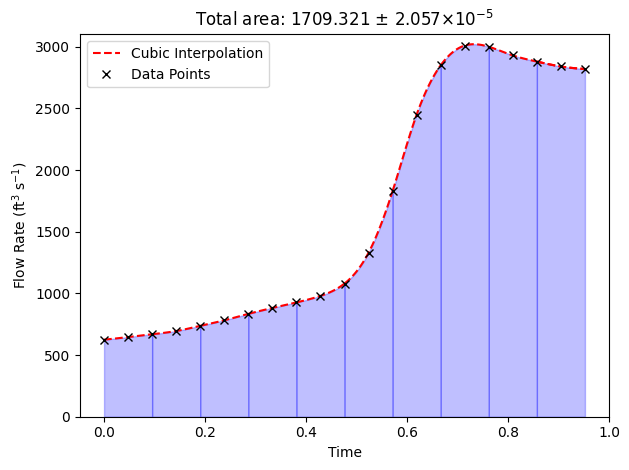

In [ ]:
def simpsons_38_integration(x, y, dx):
    # If there are an N number of samples, then there are an (N-1)
    # number of intervals. Simpson's 3/8 rule requires an 3n number
    # of intervals. Hence in case of 3n-1 or 3n-2 intervals, we approximate the end points
    # similar to what we did for Simpson's 1/3 rule
    if len(x) % 3 == 0: # (n-1)%3 = 2
        res = y[0] + 3*(np.sum(y[1:-3:3])+np.sum(y[2:-3:3])) + 2*np.sum(y[3:-3:3])+ y[-3]
        res += y[1] + 3*(np.sum(y[2:-2:3])+np.sum(y[3:-2:3])) + 2*np.sum(y[4:-2:3])+ y[-2]
        res += y[2] + 3*(np.sum(y[3:-1:3])+np.sum(y[4:-1:3])) + 2*np.sum(y[5:-1:3])+ y[-1]
        res *= (3*dx/8) * (1/3)
        res += dx*(y[0] + y[-1])
    elif len(x) % 3 == 1: # (n-1)%3 = 0
        res = y[0] + 3*(np.sum(y[1:-1:3])+np.sum(y[2:-1:3])) + 2*np.sum(y[3:-1:3])+ y[-1]
        res *= (3*dx/8)
    elif len(x) % 3 == 2: #(n-1)%3 = 1
        res = y[0] + 3*(np.sum(y[1:-2:3])+np.sum(y[2:-2:3])) + 2*np.sum(y[3:-2:3])+ y[-2]
        res += y[1] + 3*(np.sum(y[2:-1:3])+np.sum(y[3:-1:3])) + 2*np.sum(y[4:-1:3])+ y[-1]
        res *= (3*dx/8) * (1/2)
        res += 0.5*dx*(y[0] + y[-1])

    f4epsilon = np.max(abs(d4dt(y)))
    max_error_simpsons38 = ((x[-1]-x[0]) * f4epsilon * (dx**4))/(80)
    return res, max_error_simpsons38

""" plotting quadratic interpolation"""
cubic = interp1d(t1, f1, kind='cubic')
for j in range(0, len(t1)-2, 2):
    xquad = np.linspace(t1[j], t1[j+2], 25)
    plt.plot(xquad, cubic(xquad), '--r')
    plt.fill_between(xquad, cubic(xquad), alpha = 0.25, color='b')
plt.plot(xquad, cubic(xquad), '--r', label='Cubic Interpolation')

plt.plot(t1, f1, 'kx', alpha=1, label='Data Points')

plt.legend()
plt.xlabel('Time')
plt.ylim(0,3100)
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
simpsons_38, max_error_simpsons_38 = simpsons_38_integration(t1, f1, dx)
plt.title(f'Total area: {simpsons_38:.3f}' + r' $\pm$ ' + f'{max_error_simpsons_38*1e5:.3f}' + r'$\times 10^{-5}$')
plt.tight_layout()
plt.savefig('plots/2/simpsons38.png', dpi=200)

all together plot

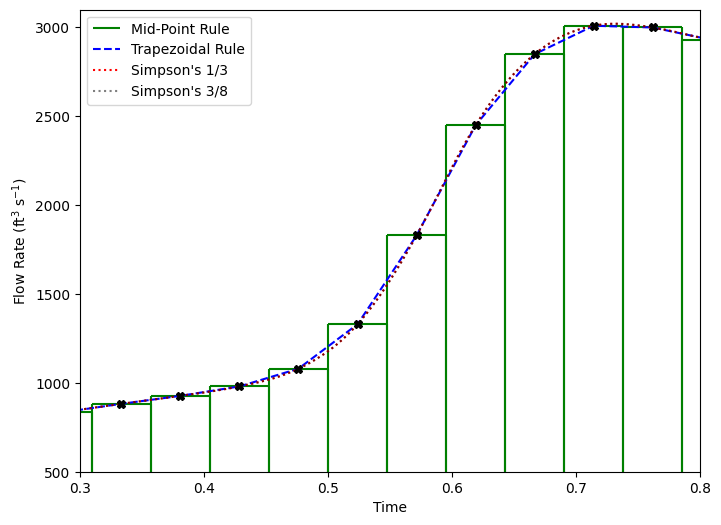

In [317]:
plt.figure(figsize=(8,6))
# mid - point
cl = 'g'
plt.vlines(t1[0], ymax=f1[0], ymin=0, color=cl, label='Mid-Point Rule')
plt.hlines(f1[0], xmin=t1[0], xmax=t1[0]+half_step, color=cl)
for i in range(1,len(t1)-1,k):
    plt.vlines(t1[i]-half_step, ymax=f1[i], ymin=0, color=cl)
    plt.vlines(t1[i]+half_step, ymax=f1[i], ymin=0, color=cl)
    plt.hlines(f1[i], xmin=t1[i]-half_step, xmax=t1[i]+half_step, color=cl)
plt.vlines(t1[-1]-half_step, ymax=f1[-1], ymin=0, color=cl)
plt.vlines(t1[-1], ymax=f1[-1]-half_step, ymin=0, color=cl)
plt.vlines(t1[-1], ymax=f1[-1], ymin=0, color=cl)
plt.hlines(f1[-1], xmin=t1[-1], xmax=t1[-1]-half_step, color=cl)

# trapz
plt.plot(t1, f1, '--b', alpha=1, label='Trapezoidal Rule')

# simpsons
quadratic = interp1d(t1, f1, kind='quadratic')
for j in range(0, len(t1)-3, 2):
    xquad = np.linspace(t1[j], t1[j+2], 25)
    plt.plot(xquad, quadratic(xquad), ':r')
xquad = np.linspace(t1[-3], t1[-1], 25)
plt.plot(xquad, quadratic(xquad), ':r', label='Simpson\'s 1/3')

cubic = interp1d(t1, f1, kind='cubic')
for j in range(0, len(t1)-3, 2):
    xquad = np.linspace(t1[j], t1[j+2], 25)
    plt.plot(xquad, cubic(xquad), ':k', alpha=0.5)
xquad = np.linspace(t1[-3], t1[-1], 25)
plt.plot(xquad, cubic(xquad), ':k', label='Simpson\'s 3/8', alpha=0.5)

plt.plot(t1, f1, 'kX', alpha=1)

plt.xlabel('Time')
plt.ylim(500,3100)
plt.xlim(0.3,0.8)
plt.ylabel('Flow Rate (ft$^3$ s$^{-1}$)')
plt.legend()
plt.savefig('plots/2/combined.png', dpi=200)

## Results

For the smaller region of interest

In [318]:
print(f'Mid-point: {mid_point} ± {max_error_trapz}')
print(f'Trapezoidal: {trapezoidal} ± {max_error_trapz}')
print(f'Simpsons 1/3: {simpsons_13} ± {max_error_simpsons_13}')
print(f'Simpsons 3/8: {simpsons_38} ± {max_error_simpsons_38}')

Mid-point: 1709.0238095238092 ± 0.04724111866969009
Trapezoidal: 1709.0238095238094 ± 0.04724111866969009
Simpsons 1/3: 1709.0158730158728 ± 9.141138608798687e-06
Simpsons 3/8: 1709.3214285714284 ± 2.0567561869797045e-05


For the entire domain

In [ ]:
""" Convert the domain to [0, 1] for simplicity in calculation of errors 
and then multiply by t_final (t_inital = 0)"""
tmax = t[-1]-t[0] 
int_t = t/np.max(t)
dx = int_t[1]-int_t[0]

mid_point, max_error_mid_point = mid_point_integration(int_t, flow)
trapezoidal, max_error_trapz = trapezoidal_integration(int_t, flow, dx)
simpsons_13, max_error_simpsons13 = simpsons_13_integration(int_t, flow, dx)
simpsons_38, max_error_simpsons38 = simpsons_38_integration(int_t, flow, dx)

print(f'Mid-point: {mid_point*tmax*1e-9:.3f} x 10^9 \pm {max_error_mid_point*tmax*(900**2)*1e-5:.3f} x 10^5 ft^3')
print(f'Trapezoidal: {trapezoidal*tmax*1e-9:.3f} x 10^9 \pm {max_error_trapz*tmax*(900**2)*1e-5:.3f} x 10^5 ft^3')
print(f'Simpsons 1/3: {simpsons_13*tmax*1e-9:.3f} x 10^9 \pm {max_error_simpsons13*tmax*(900**4):.3f} ft^3')
print(f'Simpsons 3/8: {simpsons_38*tmax*1e-9:.3f} x 10^9 \pm {max_error_simpsons38*tmax*(900**4):.3f} ft^3')

Mid-point: 23.207 x 10^9 \pm 2.167 x 10^5 ft^3
Trapezoidal: 23.207 x 10^9 \pm 4.335 x 10^5 ft^3
Simpsons 1/3: 23.207 x 10^9 \pm 24.405 ft^3
Simpsons 3/8: 23.207 x 10^9 \pm 54.910 ft^3
